In [83]:
import networkx as nx
import os
from pathlib import Path
import pandas as pd
import numpy as np
import math
from scipy import stats
from scipy.stats import linregress, zscore, poisson, norm
import re
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from plottable import Table
from plottable import ColumnDefinition
from plottable.plots import image
import seaborn as sns
from networkx.algorithms import bipartite
import statistics
import statsmodels.api as sm
from scipy.optimize import curve_fit

In [61]:
# SETUP

xferpath = Path(r"C:\Users\User\Documents\cfb project\data\transferportal\cleaned")
recpath = Path(r"C:\Users\User\Documents\cfb project\data\recruiting\bip")
projectedpath = Path(r"C:\Users\User\Documents\cfb project\data\recruiting\projections\combined")
xferfiles = {}
recfiles = {}
recfilesproj = {}

for file_path in xferpath.glob('*_cleaned.graphml'):
    name = file_path.stem.replace('_cleaned', '')
    G_x = nx.read_graphml(file_path)
    xferfiles[name] = G_x

for file_path in recpath.glob('*.graphml'):
    name = file_path.stem
    G_r = nx.read_graphml(file_path)
    recfiles[name] = G_r

for file_path in projectedpath.glob('*.graphml'):
    name = file_path.stem
    G_p = nx.read_graphml(file_path)
    recfilesproj[name] = G_p

nd_npv_ppa_df = pd.read_csv(r'C:\Users\User\Documents\cfb project\data\analysis\xfer\nd_npv\degree_analysis_ppa.csv')
nd_npv_df = pd.read_csv(r'C:\Users\User\Documents\cfb project\data\analysis\xfer\nd_npv\degree_analysis_rating.csv')
comprehensive_metrics_df = pd.read_csv(r'C:\Users\User\Documents\cfb project\data\analysis\metrics\ctm_new_and_not_improved.csv')
teamratings_df = pd.read_csv(r'C:\Users\User\Documents\cfb project\data\supplemental\team_performance.csv')
playerratings_df = pd.read_csv(r'C:\Users\User\Documents\cfb project\data\supplemental\player_performance.csv', encoding='latin1')
rosters_df = pd.read_csv(r'C:\Users\User\Documents\cfb project\data\supplemental\rosters.csv', dtype={5: str})

print(f"\nSuccessfully loaded {len(xferfiles)} files from xfer, {len(recfiles)} files from rec, {len(recfilesproj)} files from projected, and supplemental data")



Successfully loaded 5 files from xfer, 27 files from rec, 27 files from projected, and supplemental data


In [ ]:
# ND/NPV

# 1. DEFINE CALCULATION LOGIC

def nd_npv_rating(G):
    """
    Calculate NPV for each school based on summing individual player ratings.
    Includes uncertainty bounds for missing data.
    """
    school_stats = {}
    
    for node in G.nodes():

        in_transfers = []
        out_transfers = []
        in_missing = 0
        out_missing = 0
        
        # incoming
        for pred in G.predecessors(node):
            for key, data in G[pred][node].items():
                rating = data.get('ratings', '')
                try:
                    # check if rating is a valid number
                    if rating and str(rating) not in ['', '0.0', 'None', 'nan']:
                        in_transfers.append(float(rating))
                    else:
                        in_missing += 1
                except ValueError:
                    in_missing += 1
        
        # outgoing
        for succ in G.successors(node):
            for key, data in G[node][succ].items():
                rating = data.get('ratings', '')
                try:
                    if rating and str(rating) not in ['', '0.0', 'None', 'nan']:
                        out_transfers.append(float(rating))
                    else:
                        out_missing += 1
                except ValueError:
                    out_missing += 1
        
        # calculate sums
        in_sum = sum(in_transfers)
        out_sum = sum(out_transfers)
        npv = in_sum - out_sum
        
        # calculate uncertainty bounds
        best_case_npv = (in_sum + in_missing * 0.95) - (out_sum + out_missing * 0.75)
        worst_case_npv = (in_sum + in_missing * 0.75) - (out_sum + out_missing * 0.95)
        
        # assumed npv is the midpoint
        assumed_npv = (best_case_npv + worst_case_npv) / 2
        
        # if no missing data, assumed is just raw npv
        if (in_missing + out_missing) == 0:
            assumed_npv = npv
            
        uncertainty = (best_case_npv - worst_case_npv) / 2
        
        conference = G.nodes[node].get('conference')
        classification = G.nodes[node].get('classification')

        school_stats[node] = {
            'conference': conference,
            'classification': classification,
            'NPV_raw': round(npv, 2),
            'NPV_assumed': round(assumed_npv, 2),
            'in_wt': round(in_sum, 2),
            'out_wt': round(out_sum, 2),
            'net_degree': len(in_transfers) - len(out_transfers),
            'in_count': len(in_transfers),
            'out_count': len(out_transfers),
            'in_missing': in_missing,
            'out_missing': out_missing,
            'missing': in_missing + out_missing,
            'uncertainty': round(uncertainty, 2),
            'NPV_high': round(best_case_npv, 2),
            'NPV_low': round(worst_case_npv, 2)
        }
    
    return school_stats

# 2. EXECUTE AND BUILD DATAFRAME

all_npv_records = []

print("Processing files...")

for filename, G in xferfiles.items():
    # extract year from filename
    year_match = re.search(r'(\d{4})', filename)
    if year_match:
        year = int(year_match.group(1))
        
        # calculate stats for this year
        stats = nd_npv_rating(G)
        
        # flatten into list of dicts
        for school, data in stats.items():
            record = data.copy()
            record['school'] = school
            record['year'] = year
            all_npv_records.append(record)
    else:
        print(f"  Warning: Could not extract year from {filename}")

# create df
npv_df = pd.DataFrame(all_npv_records)

# 3. CALCULATE STANDARDIZED METRICS

if not npv_df.empty:
    # standardize school names
    npv_df['school'] = npv_df['school'].astype(str).str.strip()
    
    # calculate z scores of assumed npv by specific year
    npv_df['NPV_zscore'] = npv_df.groupby('year')['NPV_assumed'].transform(
        lambda x: zscore(x, nan_policy='omit')
    )
    
    # calculate percentiles
    npv_df['NPV_percentile'] = npv_df.groupby('year')['NPV_assumed'].rank(pct=True) * 100
    
    # round to 2 decimal places
    npv_df['NPV_zscore'] = npv_df['NPV_zscore'].round(2)
    npv_df['NPV_percentile'] = npv_df['NPV_percentile'].round(2)

    # reorder columns
    cols = ['year', 'school', 'classification', 'conference', 'NPV_zscore', 
            'NPV_percentile', 'NPV_raw', 'NPV_assumed', 
            'net_degree', 'in_count', 'out_count', 
            'in_wt', 'out_wt', 'uncertainty', 'NPV_high', 'NPV_low',
            'missing', 'in_missing', 'out_missing']
            
    # keep only columns that exist (in case no missing data found)
    cols = [c for c in cols if c in npv_df.columns]
    npv_df = npv_df[cols]

    print(f"\nSuccessfully created npv_df with {len(npv_df)} records.")
    print(f"Years covered: {sorted(npv_df['year'].unique())}")
    print("\nSample Data (first 5 rows):")
    print(npv_df[['year', 'school', 'NPV_zscore', 'NPV_raw', 'NPV_assumed']].head().to_string())
else:
    print("Error: No data records generated.")

In [ ]:
# COMPREHENSIVE TALENT METRICS CALCULATION
# RVI, GVO, NPV, TD, PCR

# TODO: Fix RVI z-scores not showing up
# TODO: Rework roster churn formula for pre-portal years

# STEP 1: EXTRACT RECRUITING DATA & METADATA

print("\nStep 1: Processing recruiting data & extracting fallback metadata...")

all_recruits = []
school_metadata_fallback = {} # (year, school) -> {conf, class} for years/teams not in npv df

for year in range(2000, 2026):
    graph_name = f"recruiting_network_{year}"
    
    if graph_name not in recfiles:
        # print(f"  Warning: {graph_name} not found, skipping...")
        continue
    
    G = recfiles[graph_name]
    count_for_year = 0
    
    # 1. iterate edges to get recruits and metadata
    for u, v, key, data in G.edges(data=True, keys=True):
        school_node = None
        
        # identify school node
        if G.nodes[v].get('type') == 'School':
            school_node = v
        elif G.nodes[u].get('type') == 'School':
            school_node = u
            
        if school_node:
            school_name = str(school_node).strip()
            
            # extract metadata (as fallback for non-NPV years)
            if (year, school_name) not in school_metadata_fallback:
                node_attrs = G.nodes[school_node]
                school_metadata_fallback[(year, school_name)] = {
                    'classification': node_attrs.get('classification', 'Unknown'),
                    'conference': node_attrs.get('conference', 'Unknown')
                }

            # 3. extract recruit data
            rating = data.get('rating', None)
            stars = data.get('stars', None)
            
            if rating is not None:
                try:
                    rating_val = float(rating)
                    if rating_val > 0:
                        all_recruits.append({
                            'year': year,
                            'school': school_name,
                            'player_name': data.get('player'),
                            'recruit_id': data.get('id'),
                            'athlete_id': data.get('athlete_id'),
                            'rating': rating_val,
                            'stars': int(stars) if stars else None,
                            'position': data.get('position')
                        })
                        count_for_year += 1
                except (ValueError, TypeError):
                    continue

    print(f"  {year}: Found {count_for_year} recruits")

df_recruits = pd.DataFrame(all_recruits)

# metrics for recruits
if not df_recruits.empty:
    df_recruits['school'] = df_recruits['school'].astype(str).str.strip()
    print("  Calculating recruiting Z-scores (Player Level)...")
    df_recruits['rating_percentile'] = df_recruits.groupby('year')['rating'].rank(pct=True) * 100
    df_recruits['rating_zscore'] = df_recruits.groupby('year')['rating'].transform(lambda x: zscore(x, nan_policy='omit'))
else:
    print("CRITICAL WARNING: No recruits found.")

# STEP 2: BUILD PLAYER TRACKING (For GVO)

print("\nStep 2: Building player tracking system...")
player_recruit_info = {}
for _, row in df_recruits.iterrows():
    aid = str(row['athlete_id']) if pd.notna(row['athlete_id']) else None
    if aid and aid != 'Unknown':
        player_recruit_info[aid] = {
            'rating': row['rating'],
            'rating_zscore': row['rating_zscore'],
            'rating_percentile': row['rating_percentile']
        }

# STEP 3: IDENTIFY GRADUATING PLAYERS (GVO)

print("\nStep 3: Identifying graduating players...")
rosters_df['player_id'] = rosters_df['player_id'].astype(str)
rosters_df['year'] = rosters_df['year'].astype(int)

graduating_players = []
for year in range(2000, 2025):
    curr = rosters_df[rosters_df['year'] == year]
    nxt = rosters_df[rosters_df['year'] == year + 1]
    next_ids = set(nxt['player_id'].unique())
    
    for _, player in curr.iterrows():
        if player['player_id'] not in next_ids:
            rec_info = player_recruit_info.get(str(player['player_id']), None)
            graduating_players.append({
                'grad_year': year,
                'school': str(player['team']).strip(),
                'rating': rec_info['rating'] if rec_info else None,
                'rating_zscore': rec_info['rating_zscore'] if rec_info else None,
                'rating_percentile': rec_info['rating_percentile'] if rec_info else None
            })

df_graduating = pd.DataFrame(graduating_players)
print(f"  Identified {len(df_graduating)} graduating players")

# STEP 4: AGGREGATE RVI & GVO

print("\nStep 4: Aggregating RVI and GVO...")

# RVI
rvi_agg = df_recruits.groupby(['year', 'school']).agg({
    'rating_zscore': 'sum', 'rating_percentile': 'sum', 'rating': 'sum', 'recruit_id': 'count'
}).rename(columns={
    'rating_zscore': 'RVI_zscore', 'rating_percentile': 'RVI_percentile', 
    'rating': 'RVI_raw', 'recruit_id': 'RVI_count'
}).reset_index()

# GVO
gvo_agg = df_graduating[df_graduating['rating'].notna()].groupby(['grad_year', 'school']).agg({
    'rating_zscore': 'sum', 'rating_percentile': 'sum', 'rating': 'sum', 'rating': 'count' # count gives player count
}).rename(columns={
    'rating_zscore': 'GVO_zscore', 'rating_percentile': 'GVO_percentile', 
    'rating': 'GVO_count' # re-mapped below for raw vs count
}).reset_index().rename(columns={'grad_year': 'year'})

# Fix GVO Raw/Count (the agg above overwrote rating sum with count)
gvo_agg = df_graduating[df_graduating['rating'].notna()].groupby(['grad_year', 'school']).agg({
    'rating_zscore': 'sum', 'rating_percentile': 'sum', 'rating': 'sum'
}).rename(columns={'rating_zscore': 'GVO_zscore', 'rating_percentile': 'GVO_percentile', 'rating': 'GVO_raw'}).reset_index().rename(columns={'grad_year': 'year'})

gvo_counts = df_graduating.groupby(['grad_year', 'school']).size().reset_index(name='GVO_total_count').rename(columns={'grad_year': 'year'})
# rated count
gvo_rated_counts = df_graduating[df_graduating['rating'].notna()].groupby(['grad_year', 'school']).size().reset_index(name='GVO_count').rename(columns={'grad_year': 'year'})

# STEP 5: PREPARE NPV

print("\nStep 5: Preparing NPV data from nd_npv_df...")

if 'nd_npv_df' in locals():
    npv_data = nd_npv_df.copy()
    
    # 1. standardize school
    if 'school' not in npv_data.columns and 'team' in npv_data.columns:
        npv_data = npv_data.rename(columns={'team': 'school'})
    npv_data['school'] = npv_data['school'].astype(str).str.strip()
    
    # 4. calculate z score if not present
    if 'NPV_zscore' not in npv_data.columns and 'NPV_assumed' in npv_data.columns:
        print("  Calculating NPV z-scores...")
        npv_data['NPV_zscore'] = npv_data.groupby('year')['NPV_assumed'].transform(lambda x: zscore(x, nan_policy='omit'))
    
    print(f"  Loaded NPV data: {len(npv_data)} records")
else:
    print("  CRITICAL ERROR: nd_npv_df not found.")
    npv_data = pd.DataFrame(columns=['year', 'school'])

# STEP 6: MASTER MERGE

print("\nStep 6: Creating Master DataFrame...")

# 1. create spine from all sources
sources = [rvi_agg[['year', 'school']], gvo_agg[['year', 'school']], npv_data[['year', 'school']]]
# add fallback metadata keys to spine to ensure pre-2021 teams exist
fb_keys = [{'year': k[0], 'school': k[1]} for k in school_metadata_fallback.keys()]
if fb_keys: sources.append(pd.DataFrame(fb_keys))

master = pd.concat([df for df in sources if not df.empty]).drop_duplicates().sort_values(['year', 'school'])

# 2. merge data
merged = master.merge(rvi_agg, on=['year', 'school'], how='left')
merged = merged.merge(gvo_agg, on=['year', 'school'], how='left')
merged = merged.merge(gvo_counts, on=['year', 'school'], how='left')
merged = merged.merge(gvo_rated_counts, on=['year', 'school'], how='left')
merged = merged.merge(npv_data, on=['year', 'school'], how='left')

# 3. handle metadata (conference/classification)
#    priority 1: use what's in npv_data
#    priority 2: se fallback from recruiting graphs
if 'conference' not in merged.columns:
    # use fallback dict
    def get_meta(row, col):
        key = (row['year'], row['school'])
        if key in school_metadata_fallback:
            return school_metadata_fallback[key].get(col, 'Unknown')
        return 'Unknown'
        
    merged['conference'] = merged.apply(lambda x: get_meta(x, 'conference'), axis=1)
    merged['classification'] = merged.apply(lambda x: get_meta(x, 'classification'), axis=1)
else:
    # if merged from npv, fill gaps using fallback for non-npv years
    # because npv data likely only exists for 2021
    print("  Using existing metadata columns, filling gaps...")
    for idx, row in merged[merged['conference'].isna()].iterrows():
        key = (row['year'], row['school'])
        if key in school_metadata_fallback:
            merged.at[idx, 'conference'] = school_metadata_fallback[key].get('conference', 'Unknown')
            merged.at[idx, 'classification'] = school_metadata_fallback[key].get('classification', 'Unknown')

# fill metric NaNs with 0 for calculation
metric_cols = [c for c in merged.columns if any(x in c for x in ['RVI', 'GVO', 'NPV'])]
merged[metric_cols] = merged[metric_cols].fillna(0)

# STEP 7: CALCULATE COMPOSITE METRICS

print("\nStep 7: Calculating TD and PCR...")

# 1. calculate team-level z scores for rvi and gvo
merged['RVI_team_zscore'] = merged.groupby('year')['RVI_raw'].transform(
    lambda x: zscore(x, nan_policy='omit')
)

merged['GVO_team_zscore'] = merged.groupby('year')['GVO_raw'].transform(
    lambda x: zscore(x, nan_policy='omit')
)

# 2. calculate talent delta
merged['TD_zscore'] = (
    merged['RVI_team_zscore'].fillna(0) + 
    merged['NPV_zscore'].fillna(0) - 
    merged['GVO_team_zscore'].fillna(0)
)

merged['TD_raw'] = merged['RVI_raw'] + merged['NPV_raw'] - merged['GVO_raw']
merged['TD_count'] = merged['RVI_count'] + merged['net_degree'] - merged['GVO_count']

# 3. calculate portal contribution ratio (pcr)

# FIXED: Calculate ratio FIRST, then z-score it

# Calculate raw ratio
merged['PCR_raw_ratio'] = np.where(
    merged['RVI_raw'] > 0, 
    merged['NPV_assumed'] / merged['RVI_raw'], 
    np.nan
)

# THEN z-score the ratio within each year
merged['PCR_zscore'] = merged.groupby('year')['PCR_raw_ratio'].transform(
    lambda x: zscore(x, nan_policy='omit')
)

# Keep the raw ratio as PCR_raw (more interpretable than the ratio itself)
merged['PCR_raw'] = merged['PCR_raw_ratio']

# Count-based version (also useful)
merged['PCR_count_ratio'] = np.where(
    merged['RVI_count'] > 0,
    merged['net_degree'] / merged['RVI_count'],
    np.nan
)

merged['PCR_count'] = merged.groupby('year')['PCR_count_ratio'].transform(
    lambda x: zscore(x, nan_policy='omit')
)

print(f"  PCR_zscore range: {merged['PCR_zscore'].min():.2f} to {merged['PCR_zscore'].max():.2f}")

# 4. roster churn
roster_sizes = rosters_df.groupby(['year', 'team']).size().reset_index(name='roster_size')
merged = merged.merge(roster_sizes, left_on=['year', 'school'], right_on=['year', 'team'], how='left')
merged = merged.drop(columns=['team'])

merged['new_players'] = merged['RVI_count'] + merged['in_count']
merged['roster_churn_pct'] = np.where(
    merged['roster_size'] > 0,
    (merged['new_players'] / merged['roster_size']) * 100,
    0
)

# 5. calculate team-level percentiles
#    this replaces the "sum of player percentiles" with "rank of team total"
merged['RVI_percentile'] = merged.groupby('year')['RVI_raw'].rank(pct=True) * 100
merged['GVO_percentile'] = merged.groupby('year')['GVO_raw'].rank(pct=True) * 100

# STEP 8: FINALIZE AND SAVE

print("\nStep 8: Finalizing output...")

# 1. Replace Player-Sum Z-Scores with Team-Level Z-Scores
#    This effectively swaps the metric in the final output
merged['RVI_zscore'] = merged['RVI_team_zscore'].fillna(0)
merged['GVO_zscore'] = merged['GVO_team_zscore'].fillna(0)

# 2. define strict column order
column_order = [
    # metadata
    'year', 'school', 'classification', 'conference',
    
    # composite metrics
    'TD_zscore', 'TD_raw', 'TD_count',
    'PCR_zscore', 'PCR_raw', 'PCR_raw_ratio', 'PCR_count'
    
    # rvi
    'RVI_zscore', 'RVI_percentile', 'RVI_raw', 'RVI_count',
    
    # gvo
    'GVO_zscore', 'GVO_percentile', 'GVO_raw', 'GVO_count', 'GVO_total_count',
    
    # npv
    'NPV_zscore', 'NPV_percentile', 'NPV_raw', 'NPV_assumed', 'NPV_net_count',
    
    # roster context
    'roster_size', 'new_players', 'roster_churn_pct'
]

# 3. filter and round
# keep only the columns defined above that exist in the dataframe
final_columns = [col for col in column_order if col in merged.columns]
final_df = merged[final_columns]

# round numeric columns
numeric_cols = final_df.select_dtypes(include=[np.number]).columns
final_df[numeric_cols] = final_df[numeric_cols].round(2)

# 4. save
output_path = Path(r"C:\Users\User\Documents\cfb project\data\analysis") / "comprehensive_talent_metrics.csv"
try:
    final_df.to_csv(output_path, index=False)
    print(f"\n✓ Saved to: {output_path}")
    print(f"  Final Data Shape: {final_df.shape}")
except Exception as e:
    print(f"\n❌ Error saving file: {e}")

# sample output
print("\nTop 5 Schools by TD_raw in 2024:")
sample = final_df[final_df['year'] == 2024].nlargest(5, 'TD_raw')[
    ['year', 'school', 'TD_raw', 'RVI_zscore', 'NPV_zscore', 'GVO_zscore']
]
print(sample.to_string(index=False))

In [ ]:
# SAVE RESULTS (1 FOR RATING, 2 FOR PPA, 0 FOR NEITHER)
switch = 0
if switch == 1: # prevent accidental overwrite
    output_path = Path(r"C:\Users\User\Documents\cfb project\data\analysis\nd_npv") / f"degree_analysis_rating.csv"
    npv_df.to_csv(output_path, index=False)

    print('NPV by rating successful')

if switch == 2:
    output_path = Path(r"C:\Users\User\Documents\cfb project\data\analysis\nd_npv") / f"degree_analysis_ppa.csv"
    final_df.to_csv(output_path, index=False)

    print('NPV by PPA successful')

if switch == 0:
    print("Switch is off; operation skipped.")

NPV by rating successful


TALENT METRICS

In [ ]:
# THE TRANSFER PORTAL DIVERGENCE
# Visualizing talent stratification and roster instability
# ============================================

print("\nGenerating Transfer Portal Divergence visualization...")

# Load the comprehensive metrics
df = comprehensive_metrics_df.copy()

# Calculate annual metrics
annual_stats = df.groupby('year').agg({
    'TD_zscore': ['std', 'mean'],  # Talent concentration
    'roster_churn_pct': 'mean',     # Average roster turnover
    'PCR_zscore': 'std'             # Portal reliance variation
}).reset_index()

# Flatten column names
annual_stats.columns = ['year', 'TD_std', 'TD_mean', 'churn_mean', 'PCR_std']

# Filter to years with sufficient data
annual_stats = annual_stats[annual_stats['year'] >= 2000]

print(f"  Years analyzed: {annual_stats['year'].min()} - {annual_stats['year'].max()}")

# ============================================
# CREATE DUAL-AXIS PLOT
# ============================================

fig, ax1 = plt.subplots(figsize=(14, 8))

# PRIMARY AXIS: Talent Concentration (TD Standard Deviation)
color1 = 'darkred'
ax1.set_xlabel('Year', fontsize=14, fontweight='bold')
ax1.set_ylabel('Talent Concentration\n(Std Dev of TD Z-score)', 
               fontsize=14, fontweight='bold', color=color1)
line1 = ax1.plot(annual_stats['year'], annual_stats['TD_std'], 
                 color=color1, linewidth=3, marker='o', markersize=6, 
                 label='Talent Concentration', zorder=3)
ax1.tick_params(axis='y', labelcolor=color1, labelsize=12)
ax1.tick_params(axis='x', labelsize=12)
ax1.grid(True, alpha=0.3, linestyle='--')

# SECONDARY AXIS: Roster Churn
ax2 = ax1.twinx()
color2 = 'darkblue'
ax2.set_ylabel('Average Roster Churn (%)', 
               fontsize=14, fontweight='bold', color=color2)
line2 = ax2.plot(annual_stats['year'], annual_stats['churn_mean'], 
                 color=color2, linewidth=3, marker='s', markersize=6, 
                 label='Roster Churn %', zorder=3)
ax2.tick_params(axis='y', labelcolor=color2, labelsize=12)

# ============================================
# ADD PORTAL ERA DEMARCATION
# ============================================

# Vertical line at 2021 (portal era begins)
ax1.axvline(x=2021, color='black', linestyle='--', linewidth=2, 
            alpha=0.7, label='Transfer Portal Era', zorder=2)

# Shaded regions
ax1.axvspan(annual_stats['year'].min(), 2021, alpha=0.1, color='gray', 
            label='Pre-Portal Era')
ax1.axvspan(2021, annual_stats['year'].max(), alpha=0.1, color='orange', 
            label='Portal Era')

# ============================================
# CALCULATE TREND LINES
# ============================================

# Pre-portal trend (2000-2020)
pre_portal = annual_stats[annual_stats['year'] <= 2020]
if len(pre_portal) > 1:
    slope_pre, intercept_pre, r_pre, p_pre, _ = stats.linregress(
        pre_portal['year'], pre_portal['TD_std']
    )
    ax1.plot(pre_portal['year'], 
             slope_pre * pre_portal['year'] + intercept_pre,
             color=color1, linestyle=':', linewidth=2, alpha=0.5, 
             label=f'Pre-Portal Trend (slope={slope_pre:.3f})')

# Post-portal trend (2021+)
post_portal = annual_stats[annual_stats['year'] >= 2021]
if len(post_portal) > 1:
    slope_post, intercept_post, r_post, p_post, _ = stats.linregress(
        post_portal['year'], post_portal['TD_std']
    )
    ax1.plot(post_portal['year'], 
             slope_post * post_portal['year'] + intercept_post,
             color=color1, linestyle=':', linewidth=2, alpha=0.8, 
             label=f'Post-Portal Trend (slope={slope_post:.3f})')

# ============================================
# FORMATTING
# ============================================

# Title
plt.title('The Transfer Portal Divergence:\nTalent Stratification and Roster Instability (2000-2024)', 
          fontsize=16, fontweight='bold', pad=20)

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, 
           loc='upper left', fontsize=11, framealpha=0.95)

# Tight layout
fig.tight_layout()

# Save
plt.savefig('./imgs/xfer/graphs/portal_divergence.png', dpi=300, bbox_inches='tight')
plt.close()

print("✓ Portal Divergence visualization saved!")

# ============================================
# PRINT SUMMARY STATISTICS
# ============================================

print("\n" + "="*70)
print("PORTAL DIVERGENCE SUMMARY")
print("="*70)

pre_avg_td = pre_portal['TD_std'].mean()
post_avg_td = post_portal['TD_std'].mean()
td_change = ((post_avg_td - pre_avg_td) / pre_avg_td) * 100

pre_avg_churn = pre_portal['churn_mean'].mean()
post_avg_churn = post_portal['churn_mean'].mean()
churn_change = post_avg_churn - pre_avg_churn

print(f"\nTalent Concentration (TD Standard Deviation):")
print(f"  Pre-Portal Average (2000-2020):  {pre_avg_td:.3f}")
print(f"  Post-Portal Average (2021-2024): {post_avg_td:.3f}")
print(f"  Change: {td_change:+.1f}%")

print(f"\nRoster Churn:")
print(f"  Pre-Portal Average: {pre_avg_churn:.2f}%")
print(f"  Post-Portal Average: {post_avg_churn:.2f}%")
print(f"  Change: {churn_change:+.2f} percentage points")

if len(pre_portal) > 1 and len(post_portal) > 1:
    print(f"\nTrend Analysis:")
    print(f"  Pre-Portal TD trend slope: {slope_pre:.4f} (p={p_pre:.4f})")
    print(f"  Post-Portal TD trend slope: {slope_post:.4f} (p={p_post:.4f})")
    
    if slope_post > slope_pre:
        print(f"  → Talent stratification is ACCELERATING post-portal")
    else:
        print(f"  → Talent stratification is DECELERATING post-portal")

print("="*70)


Generating Transfer Portal Divergence visualization...
  Years analyzed: 2000 - 2025
✓ Portal Divergence visualization saved!

PORTAL DIVERGENCE SUMMARY

Talent Concentration (TD Standard Deviation):
  Pre-Portal Average (2000-2020):  0.951
  Post-Portal Average (2021-2024): 1.053
  Change: +10.7%

Roster Churn:
  Pre-Portal Average: 0.00%
  Post-Portal Average: 8.37%
  Change: +8.37 percentage points

Trend Analysis:
  Pre-Portal TD trend slope: -0.0252 (p=0.0017)
  Post-Portal TD trend slope: 0.0261 (p=0.5392)
  → Talent stratification is ACCELERATING post-portal


In [ ]:
# TD/PCR/PERFORMANCE SCATTER PLOTS

# Merge comprehensive metrics with team ratings
merged_analysis = comprehensive_metrics_df.merge(
    teamratings_df[['school', 'year', 'fpi', 'srs']], 
    on=['school', 'year'], 
    how='inner'  # Only keep rows where both datasets have data
)

# Drop rows with NaN in key columns
merged_analysis = merged_analysis.dropna(subset=['TD_zscore', 'PCR_zscore', 'fpi', 'srs'])

print(f"Merged dataset size: {len(merged_analysis)} school-year combinations")
print(f"Years covered: {sorted(merged_analysis['year'].unique())}")

TD = merged_analysis['TD_zscore']
PCR = merged_analysis['PCR_zscore']
FPI = merged_analysis['fpi']
SRS = merged_analysis['srs']

# TD/PERFORMANCE SCATTER (FPI AND SRS)

# FPI
plt.figure(figsize=(8, 6))
plt.scatter(TD, FPI, color='mediumblue', alpha=0.6)
slope, intercept, r_value, p_value, std_err = stats.linregress(TD, FPI)
plt.plot(TD, slope*TD + intercept, color='red', linewidth=2)
plt.xlabel('Talent Delta (Z-score)')
plt.ylabel('Team Performance (FPI)')
plt.title('Scatter Plot of TD vs FPI')
leg = plt.legend(['Schools', 'Regression Line'], title=f'Slope: {slope:.2f}\nCorrelation: {r_value:.2f}\np-value: {p_value:.4f}')
leg._legend_box.align = "left"
plt.grid(True, alpha=0.3)
plt.savefig(f'.\\imgs\\supp\\scatter_td_fpi.png', dpi=250, bbox_inches='tight')
plt.close()

# SRS
plt.figure(figsize=(8, 6))
plt.scatter(TD, SRS, color='darkolivegreen', alpha=0.6)
slope, intercept, r_value, p_value, std_err = stats.linregress(TD, SRS)
plt.plot(TD, slope*TD + intercept, color='red', linewidth=2)
plt.xlabel('Talent Delta (Z-score)')
plt.ylabel('Team Performance (SRS)')
plt.title('Scatter Plot of TD vs SRS')
leg = plt.legend(['Schools', 'Regression Line'], title=f'Slope: {slope:.2f}\nCorrelation: {r_value:.2f}\np-value: {p_value:.4f}')
leg._legend_box.align = "left"
plt.grid(True, alpha=0.3)
plt.savefig(f'.\\imgs\\supp\\scatter_td_srs.png', dpi=250, bbox_inches='tight')
plt.close()

# PCR/PERFORMANCE SCATTER (FPI AND SRS)

# FPI
plt.figure(figsize=(8, 6))
plt.scatter(PCR, FPI, color='mediumblue', alpha=0.6)
slope, intercept, r_value, p_value, std_err = stats.linregress(PCR, FPI)
plt.plot(PCR, slope*PCR + intercept, color='red', linewidth=2)
plt.xlabel('Portal Contribution Ratio (Z-score)')
plt.ylabel('Team Performance (FPI)')
plt.title('Scatter Plot of PCR vs FPI')
leg = plt.legend(['Schools', 'Regression Line'], title=f'Slope: {slope:.2f}\nCorrelation: {r_value:.2f}\np-value: {p_value:.4f}')
leg._legend_box.align = "left"
plt.grid(True, alpha=0.3)
plt.savefig(f'.\\imgs\\supp\\scatter_pcr_fpi.png', dpi=250, bbox_inches='tight')
plt.close()

# SRS
plt.figure(figsize=(8, 6))
plt.scatter(PCR, SRS, color='darkolivegreen', alpha=0.6)
slope, intercept, r_value, p_value, std_err = stats.linregress(PCR, SRS)
plt.plot(PCR, slope*PCR + intercept, color='red', linewidth=2)
plt.xlabel('Portal Contribution Ratio (Z-score)')
plt.ylabel('Team Performance (SRS)')
plt.title('Scatter Plot of PCR vs SRS')
leg = plt.legend(['Schools', 'Regression Line'], title=f'Slope: {slope:.2f}\nCorrelation: {r_value:.2f}\np-value: {p_value:.4f}')
leg._legend_box.align = "left"
plt.grid(True, alpha=0.3)
plt.savefig(f'.\\imgs\\supp\\scatter_pcr_srs.png', dpi=250, bbox_inches='tight')
plt.close()

print("\n✓ All scatter plots saved!")

In [51]:
# MODIFIED TD/PCR/PERFORMANCE

# ============================================
# STRATIFICATION ANALYSIS: TD vs Performance Over Time
# ============================================

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import stats
import numpy as np

print("\n" + "="*70)
print("STRATIFICATION ANALYSIS")
print("="*70)

analysis_df = comprehensive_metrics_df.copy()

# CRITICAL FIX: Fill missing Portal metrics with 0 for pre-2021 years
# This prevents them from being dropped as "incomplete data"
portal_cols = ['NPV_zscore', 'NPV_raw', 'PCR_zscore', 'PCR_raw']
for col in portal_cols:
    if col in analysis_df.columns:
        analysis_df[col] = analysis_df[col].fillna(0)

# 2. Merge with Performance Data
# Using 'inner' is fine as long as school names match
merged_analysis = analysis_df.merge(
    teamratings_df[['school', 'year', 'fpi', 'srs']], 
    on=['school', 'year'], 
    how='inner'
)

# 3. Filter Data
# FIX: Only drop rows missing the specific variables we are PLOTTING (TD and SRS)
# We remove 'fpi' and 'PCR_zscore' from this check to allow pre-2005 (no FPI) and pre-2021 (no PCR) years.
merged_analysis = merged_analysis.dropna(subset=['TD_zscore', 'srs'])

# Add conference tier classification
def classify_conference(conf):
    """Classify conferences as P5/P4 or G5/G6"""
    # Adjust list for historical accuracy if needed
    power_conferences = ['SEC', 'Big Ten', 'Big 12', 'ACC', 'Pac-12', 'Pac-10']
    if any(p in str(conf) for p in power_conferences):
        return 'P5'
    else:
        return 'G5'

merged_analysis['tier'] = merged_analysis['conference'].apply(classify_conference)

print(f"Merged dataset size: {len(merged_analysis)} school-year combinations")
print(f"Years covered: {sorted(merged_analysis['year'].unique())}")

# ============================================
# FIGURE 1: STRATIFICATION OVER TIME (TD vs SRS)
# ============================================

fig, ax = plt.subplots(figsize=(12, 8))

# Color by year (gradient)
years = merged_analysis['year']
normalize = plt.Normalize(vmin=years.min(), vmax=years.max())
colors = cm.viridis(normalize(years))

# Size by tier
sizes = merged_analysis['tier'].map({'P5': 100, 'G5': 50})

# Scatter plot
scatter = ax.scatter(merged_analysis['TD_zscore'], 
                     merged_analysis['srs'],
                     c=colors, 
                     s=sizes,
                     alpha=0.6,
                     edgecolors='black',
                     linewidth=0.5)

# Add colorbar for year
cbar = plt.colorbar(cm.ScalarMappable(norm=normalize, cmap='viridis'), ax=ax)
cbar.set_label('Year', fontsize=12, fontweight='bold')

# Overall regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(
    merged_analysis['TD_zscore'], 
    merged_analysis['srs']
)
x_line = np.linspace(merged_analysis['TD_zscore'].min(), 
                     merged_analysis['TD_zscore'].max(), 100)
ax.plot(x_line, slope*x_line + intercept, 
        color='red', linewidth=2, linestyle='--', 
        label=f'Overall: r={r_value:.3f}')

# ============================================
# ERA COMPARISON
# ============================================

portal_era = merged_analysis[merged_analysis['year'] >= 2021]
pre_portal = merged_analysis[merged_analysis['year'] < 2021]

print(f"\nData distribution:")
print(f"  Total observations: {len(merged_analysis)}")
print(f"  Pre-Portal (<2021): {len(pre_portal)}")
print(f"  Portal Era (2021+): {len(portal_era)}")

# Pre-portal regression line
if len(pre_portal) > 10:
    slope_pre, int_pre, r_pre, p_pre, _ = stats.linregress(
        pre_portal['TD_zscore'], pre_portal['srs']
    )
    ax.plot(x_line, slope_pre*x_line + int_pre,
            color='gray', linewidth=2.5, linestyle='-',
            label=f'Pre-Portal (<2021): r={r_pre:.3f}')
else:
    print("  ⚠ Insufficient pre-portal data for regression")

# Portal era regression line
if len(portal_era) > 10:
    slope_post, int_post, r_post, p_post, _ = stats.linregress(
        portal_era['TD_zscore'], portal_era['srs']
    )
    ax.plot(x_line, slope_post*x_line + int_post,
            color='orange', linewidth=2.5, linestyle='-',
            label=f'Portal Era (2021+): r={r_post:.3f}')
else:
    print("  ⚠ Insufficient portal era data for regression")

# Formatting
ax.set_xlabel('Talent Delta (Z-score)', fontsize=14, fontweight='bold')
ax.set_ylabel('Team Performance (SRS)', fontsize=14, fontweight='bold')
ax.set_title('Stratification Analysis: TD vs SRS Over Time\n(Comparison of Pre-Portal vs Portal Eras)', 
             fontsize=15, fontweight='bold', pad=20)
ax.legend(loc='upper left', fontsize=11, framealpha=0.95)
ax.grid(True, alpha=0.3)

# Save
output_path = Path(r"C:\Users\User\Documents\cfb project\imgs\supp") / "stratification_td_srs.png"
plt.tight_layout()
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.close()

print(f"\n✓ Stratification plot saved to: {output_path}")

# Print Analysis Results
if len(pre_portal) > 10 and len(portal_era) > 10:
    print("\nStratification Change Analysis:")
    print(f"  Pre-Portal Correlation: r = {r_pre:.3f}")
    print(f"  Portal Era Correlation: r = {r_post:.3f}")
    
    delta = abs(r_post) - abs(r_pre)
    if delta > 0:
        print(f"  RESULT: Correlation has STRENGTHENED by {delta:.3f}")
        print("  INTERPRETATION: Talent advantages are translating MORE directly to wins in the portal era.")
    else:
        print(f"  RESULT: Correlation has WEAKENED by {abs(delta):.3f}")
# ============================================
# FIGURE 2: PORTAL STRATEGY PAYOFF (PCR vs Performance Change)
# ============================================

print("\n" + "="*70)
print("PORTAL STRATEGY ANALYSIS")
print("="*70)

# Calculate year-over-year performance change
merged_analysis = merged_analysis.sort_values(['school', 'year'])
merged_analysis['fpi_change'] = merged_analysis.groupby('school')['fpi'].diff()
merged_analysis['srs_change'] = merged_analysis.groupby('school')['srs'].diff()

# Only use portal era (2021+) and rows with performance change data
portal_strategy = merged_analysis[
    (merged_analysis['year'] >= 2021) & 
    (merged_analysis['fpi_change'].notna())
]

# Classify initial performance tier
portal_strategy['performance_tier'] = pd.cut(
    portal_strategy['fpi'], 
    bins=[-np.inf, -5, 5, np.inf],
    labels=['Low', 'Mid', 'Elite']
)

fig, ax = plt.subplots(figsize=(12, 8))

# Color by performance tier
tier_colors = {'Elite': 'darkred', 'Mid': 'orange', 'Low': 'lightblue'}
for tier in ['Elite', 'Mid', 'Low']:
    tier_data = portal_strategy[portal_strategy['performance_tier'] == tier]
    if len(tier_data) > 0:
        ax.scatter(tier_data['PCR_zscore'], 
                   tier_data['fpi_change'],
                   c=tier_colors[tier],
                   s=80,
                   alpha=0.6,
                   edgecolors='black',
                   linewidth=0.5,
                   label=f'{tier} (baseline FPI)')

# Add regression lines by tier
for tier in ['Elite', 'Mid', 'Low']:
    tier_data = portal_strategy[portal_strategy['performance_tier'] == tier]
    if len(tier_data) > 5:
        slope, intercept, r, p, _ = stats.linregress(
            tier_data['PCR_zscore'].dropna(), 
            tier_data['fpi_change'].dropna()
        )
        x_line = np.linspace(tier_data['PCR_zscore'].min(), 
                             tier_data['PCR_zscore'].max(), 50)
        ax.plot(x_line, slope*x_line + intercept,
                color=tier_colors[tier], linewidth=2, linestyle='--',
                alpha=0.7)
        print(f"\n{tier} Tier: r={r:.3f}, p={p:.4f}")

# Add quadrant lines
ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax.axvline(x=0, color='black', linestyle='-', linewidth=1, alpha=0.5)

# Label quadrants
ax.text(-2, 8, 'Recruiting-Focused\n+ Improvement', 
        fontsize=10, ha='center', va='center', 
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))
ax.text(2, 8, 'Portal-Focused\n+ Improvement', 
        fontsize=10, ha='center', va='center',
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))
ax.text(-2, -8, 'Recruiting-Focused\n+ Decline', 
        fontsize=10, ha='center', va='center',
        bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.3))
ax.text(2, -8, 'Portal-Focused\n+ Decline', 
        fontsize=10, ha='center', va='center',
        bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.3))

# Formatting
ax.set_xlabel('Portal Contribution Ratio (Z-score)\n← Recruiting-Focused | Portal-Focused →', 
              fontsize=13, fontweight='bold')
ax.set_ylabel('Year-Over-Year FPI Change', fontsize=13, fontweight='bold')
ax.set_title('Portal Strategy Payoff: Does It Work? (2021-2024)', 
             fontsize=15, fontweight='bold', pad=20)
ax.legend(loc='upper right', fontsize=11, framealpha=0.95, title='Performance Tier')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./imgs/supp/portal_strategy_payoff.png', dpi=300, bbox_inches='tight')
plt.close()

print("\n✓ Portal strategy payoff plot saved!")

# Count schools in each quadrant
q1 = portal_strategy[(portal_strategy['PCR_zscore'] > 0) & (portal_strategy['fpi_change'] > 0)]
q2 = portal_strategy[(portal_strategy['PCR_zscore'] < 0) & (portal_strategy['fpi_change'] > 0)]
q3 = portal_strategy[(portal_strategy['PCR_zscore'] < 0) & (portal_strategy['fpi_change'] < 0)]
q4 = portal_strategy[(portal_strategy['PCR_zscore'] > 0) & (portal_strategy['fpi_change'] < 0)]

print("\nQuadrant Distribution (Portal Era):")
print(f"  Portal-Focused + Improvement: {len(q1)} ({len(q1)/len(portal_strategy)*100:.1f}%)")
print(f"  Recruiting-Focused + Improvement: {len(q2)} ({len(q2)/len(portal_strategy)*100:.1f}%)")
print(f"  Recruiting-Focused + Decline: {len(q3)} ({len(q3)/len(portal_strategy)*100:.1f}%)")
print(f"  Portal-Focused + Decline: {len(q4)} ({len(q4)/len(portal_strategy)*100:.1f}%)")

print("\n" + "="*70)
print("✓ ALL ANALYSES COMPLETE")
print("="*70)


STRATIFICATION ANALYSIS
Merged dataset size: 3229 school-year combinations
Years covered: [np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]

Data distribution:
  Total observations: 3229
  Pre-Portal (<2021): 2345
  Portal Era (2021+): 884

✓ Stratification plot saved to: C:\Users\User\Documents\cfb project\imgs\supp\stratification_td_srs.png

Stratification Change Analysis:
  Pre-Portal Correlation: r = -0.107
  Portal Era Correlation: r = -0.169
  RESULT: Correlation has STRENGTHENED by 0.062
  INTERPRETATION: Talent advantages are translating MORE directly to wins in the portal era.

PORTAL STRATEGY ANALYSIS

Elite Tier: r=0.116, p=0.114

C:\Users\User\AppData\Local\Temp\ipykernel_4324\2089288359.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portal_strategy['performance_tier'] = pd.cut(



✓ Portal strategy payoff plot saved!

Quadrant Distribution (Portal Era):
  Portal-Focused + Improvement: 90 (17.2%)
  Recruiting-Focused + Improvement: 168 (32.1%)
  Recruiting-Focused + Decline: 181 (34.5%)
  Portal-Focused + Decline: 75 (14.3%)

✓ ALL ANALYSES COMPLETE


In [ ]:
# ND/NPV

# ND distribution
plt.figure(figsize=(8, 5))
sns.histplot(nd_npv_df['net_degree'], discrete=True, color='cyan')
plt.title('Distribution of Net Portal Gain', fontsize=14)
plt.xlabel('Value')
plt.ylabel('Frequency')
nd_std_dev = statistics.stdev(nd_npv_df['net_degree'])
q1 = np.percentile(nd_npv_df['net_degree'], 25)
q3 = np.percentile(nd_npv_df['net_degree'], 75)
iqr = q3 - q1
plt.axvline(q1, color='green', linestyle='dashed', linewidth=1, label=f'IQR: ± {iqr/2}')
plt.axvline(q3, color='green', linestyle='dashed', linewidth=1)
plt.axvline(nd_std_dev, color='red', linestyle='dashed', linewidth=1, label=f'Std Dev: {nd_std_dev:.2f}')
plt.axvline(-nd_std_dev, color='red', linestyle='dashed', linewidth=1)
leg = plt.legend(title=f"Skewness: {nd_npv_df['net_degree'].skew():.2f}\nKurtosis: {nd_npv_df['net_degree'].kurt():.2f}", )
leg._legend_box.align = "left"
plt.tight_layout()
plt.savefig(f'.\\imgs\\xfer\\graphs\\distribution_net_degree.png', dpi=250, bbox_inches='tight')
plt.close()

# ND/NPV SCATTER (with regression line)
plt.scatter(nd_npv_df['net_degree'], nd_npv_df['NPV_assumed'])
slope, intercept, r_value, p_value, std_err = stats.linregress(nd_npv_df['net_degree'], nd_npv_df['NPV_assumed'])
plt.plot(nd_npv_df['net_degree'], slope*nd_npv_df['net_degree'] + intercept, color='red')
plt.xlabel('Net Portal Gain')
plt.ylabel('Net Portal Value')
plt.title('Scatter Plot of NPG vs NPV')
plt.legend(['Schools', 'Regression Line'], title= f'Slope: {slope:.2f}\nCorrelation: {r_value:.2f}')
plt.savefig(f'.\\imgs\\xfer\\graphs\\scatter_net_degree_vs_npv.png', dpi=250, bbox_inches='tight')
plt.close()

# IN/OUT SCATTER (with regression line)
plt.scatter(nd_npv_df['in_count'], nd_npv_df['out_count'], color='purple')
slope, intercept, r_value, p_value, std_err = stats.linregress(nd_npv_df['in_count'], nd_npv_df['out_count'])
plt.plot(nd_npv_df['in_count'], slope*nd_npv_df['in_count'] + intercept, color='red')
plt.xlabel('In-Count')
plt.ylabel('Out-Count')
plt.title('Scatter Plot of In-Count vs Out-Count')
leg = plt.legend(['Schools', 'Regression Line'], title= f'Slope: {slope:.2f}\nCorrelation: {r_value:.2f}')
leg._legend_box.align = "left"
plt.savefig(f'.\\imgs\\xfer\\graphs\\scatter_in_vs_out_degree.png', dpi=250, bbox_inches='tight')
plt.close()

# AGG METRICS BY SCHOOL

# 1. Prepare your data
school_summary_npv = nd_npv_df.groupby('school')['net_degree'].sum().reset_index().sort_values('net_degree', ascending=False)

# 2. Create explicit copies for Top and Bottom to avoid SettingWithCopy warnings
#    and manipulate their indices independently.

# --- Top 15 (Highest Net Degree) ---
df_top = school_summary_npv.head(15).copy()
df_top.reset_index(drop=True, inplace=True)  # Reset to 0, 1, 2...
df_top.index = df_top.index + 1             # Shift to 1, 2, 3...
df_top.index.name = 'Rank'                  # Set the header label

# --- Bottom 15 (Lowest Net Degree) ---
# Your logic was correct: tail(15) gets the bottom, sort_values(asc=True) puts the lowest first.
df_bottom = school_summary_npv.tail(15).sort_values('net_degree', ascending=True).copy()
df_bottom.reset_index(drop=True, inplace=True) # Reset to 0, 1, 2...
df_bottom.index = df_bottom.index + 1          # Shift to 1, 2, 3...
df_bottom.index.name = 'Rank'                  # Set the header label

# 3. Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6)) # Increased width slightly for readability
plt.suptitle('Aggregate Net Portal Gain by School', fontsize=16)

column_definitions = [ColumnDefinition(name='school', # name of the column to change
                                       title='School', # new title for the column
                                       textprops={"ha": "left"}),
                      ColumnDefinition(name='net_degree',
                                       title='Value',
                                       textprops={"ha": "right"}),
                      ColumnDefinition(name='Rank',
                                       textprops={'ha': 'right'})
                                      ]

# Create the tables
tab1 = Table(df_top, ax=axes[0], column_definitions=column_definitions)
tab2 = Table(df_bottom, ax=axes[1], column_definitions=column_definitions)
axes[0].set_title("Top", fontstyle='italic')
axes[1].set_title("Bottom", fontstyle='italic')

plt.tight_layout()

# AGG TEAM RATINGS BY SCHOOL FOR SAME YEARS

#teamratings_df['year'] = teamratings_df['season'].apply(lambda x: int(x.split('-')[0]))

COURSE-REQUIRED ANALYSES

In [ ]:
# PROJECTING BIPARTITE RECRUITING NETWORK(S)

# function to calculate shared recruit volume for weights

def shared_recruit_volume(G, u, v):
    weight = 0
    # Find all hometowns (neighbors) that both schools share
    shared_hometowns = set(G[u]) & set(G[v])
    
    for h in shared_hometowns:
        # Get the weight (number of recruits) for School U -> Hometown
        w_u = G[u][h].get('weight', 1)
        # Get the weight (number of recruits) for School V -> Hometown
        w_v = G[v][h].get('weight', 1)
        
        # chosen operation
        weight += w_u + w_v
        
    return weight

for file, B in recfiles.items():
    year = int(re.search(r'\d{4}', file).group())
    schools = {n for n, d in B.nodes(data=True) if d["bipartite"] == 0}
    hometowns = set(B) - schools
    # Collapse MultiGraph parallel edges into a single bipartite Graph where
    # each school-hometown edge has a 'weight' equal to the number of parallel edges
    G_bip_simple = nx.Graph()
    # copy nodes
    for n, d in B.nodes(data=True):
        G_bip_simple.add_node(n, **d)

    # accumulate weights (default: count parallel edges)
    edge_weights = {}
    for u, v, key, data in B.edges(keys=True, data=True):
        # determine which end is the school
        if u in schools and v not in schools:
            s, h = u, v
        elif v in schools and u not in schools:
            s, h = v, u
        else:
            # skip same-type edges (just in case)
            continue
        w = 1    
        edge_weights[(s, h)] = edge_weights.get((s, h), 0) + w

    # add aggregated edges to the simple bipartite graph
    for (s, h), w in edge_weights.items():
        G_bip_simple.add_edge(s, h, weight=w)

    # Now create a weighted projection of the school nodes
    projected = bipartite.generic_weighted_projected_graph(G_bip_simple, schools, weight_function=shared_recruit_volume)
    #nx.write_graphml(projected, f'.\\data\\recruiting\\projections\\total\\projected_{year}_total.graphml')

# COMBINING PROJECTIONS INTO SINGLE GRAPH

# Step 1: Load all projection files from subfolders
for file_path in projectedpath.rglob("*.graphml"):
    name = file_path.stem
    
    year_match = re.search(r"20\d{2}", name)
    if not year_match:
        print("SKIPPING (no year found):", name)
        continue

    year = int(year_match.group(0))

    
    # Determine projection type based on folder location + filename
    parent = file_path.parent.name.lower()
    name_lower = name.lower()

    if parent == "total":
        projection_type = "total"
    elif parent == "min":
        projection_type = "min"
    else:
        # Parent is the base `projections/` directory → DEFAULT projection
        projection_type = "places"
    
    # Load graph
    G = nx.read_graphml(file_path)
    
    # Store by year + type
    recfilesproj.setdefault(year, {})
    recfilesproj[year][projection_type] = G

# Step 2: Combine graphs year by year  
outdir = Path("data/recruiting/projections/combined")
outdir.mkdir(parents=True, exist_ok=True)

for year, proj_dict in recfilesproj.items():

    # Safety check  
    if not all(k in proj_dict for k in ["total", "places", "min"]):
        print(f"WARNING: Year {year} missing one or more projections — skipping")
        continue
    
    G_total = proj_dict["total"]
    G_places = proj_dict["places"]
    G_min = proj_dict["min"]

    # Create combined graph
    G_combined = nx.Graph()
    G_combined.add_nodes_from(G_total.nodes(data=True))

    # Union of all edges across the three graphs
    all_edges = (
        set(G_total.edges()) |
        set(G_places.edges()) |
        set(G_min.edges())
    )

    for u, v in all_edges:
        G_combined.add_edge(u, v)

        # Assign three weight attributes
        G_combined[u][v]["total_volume"] = (
            G_total[u][v].get("weight", 0) if G_total.has_edge(u, v) else 0
        )
        G_combined[u][v]["shared_places"] = (
            G_places[u][v].get("weight", 0) if G_places.has_edge(u, v) else 0
        )
        G_combined[u][v]["min_shared"] = (
            G_min[u][v].get("weight", 0) if G_min.has_edge(u, v) else 0
        )

    # Save combined file
    outfile = outdir / f"projected_combined_{year}.graphml"
    #nx.write_graphml(G_combined, outfile)

    print(f"✔ Saved {outfile}")


In [92]:
G = nx.read_graphml(r"C:\Users\User\Documents\cfb project\data\transferportal\cleaned\transfer_portal_2024_cleaned.graphml")
for node in G:
    

3


<module 'matplotlib.pyplot' from 'c:\\Users\\User\\anaconda3\\envs\\cfb\\Lib\\site-packages\\matplotlib\\pyplot.py'>

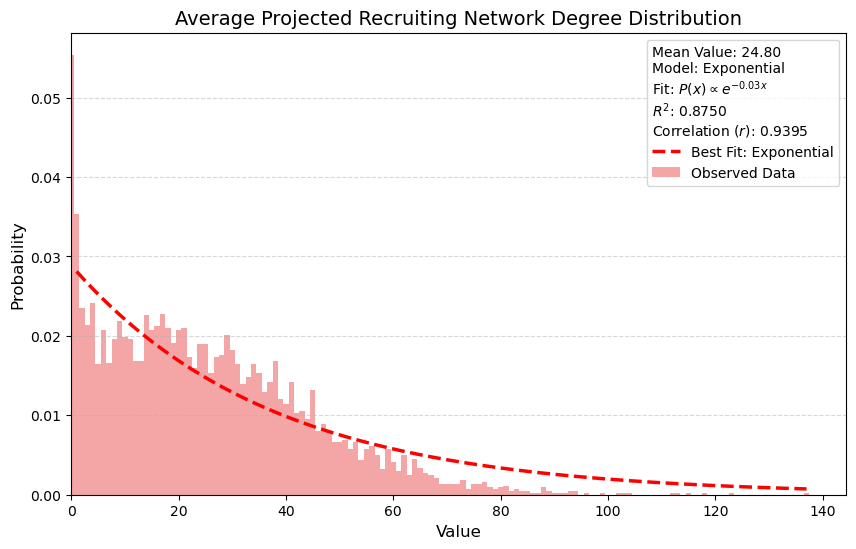

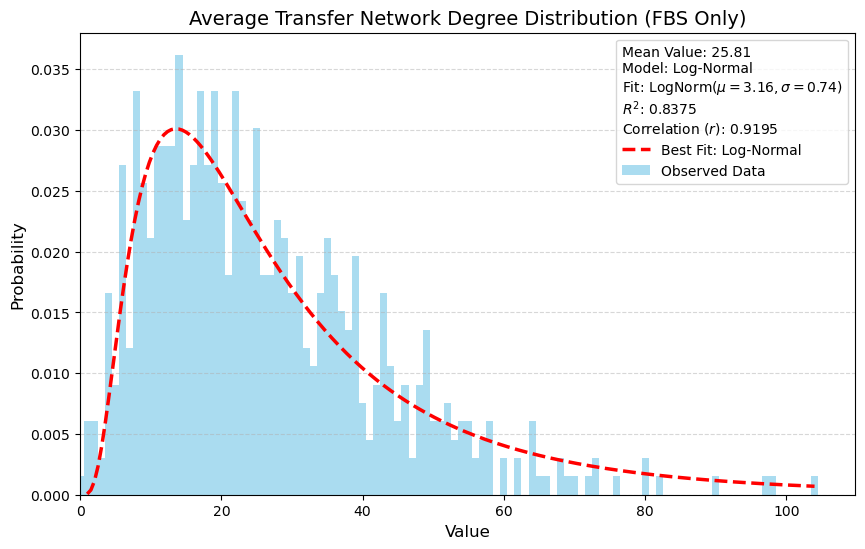

In [97]:
# PLOTTING FUNCTIONS

def fit_and_plot_best_distribution(data, title="Degree Distribution", xlabel="Value", ylabel="Probability", color='skyblue', log=False, savepath=None):
    """
    Fits Power Law, Exponential, and Log-Normal distributions to the data,
    determines the best fit via R-squared, and plots the result.
    """
    # 1. Process Data: Calculate average and create histogram/probabilities
    avg_val = np.mean(data)
    
    # Create histogram (density=True ensures area=1, but we often want P(k))
    # Using integers for bins if data is discrete-like (degrees), or auto otherwise
    if np.issubdtype(np.array(data).dtype, np.integer) and max(data) < 500:
        bins = np.arange(min(data), max(data) + 2) - 0.5
    else:
        bins = 50 
        
    counts, bin_edges = np.histogram(data, bins=bins, density=True)
    
    # Calculate bin centers
    x = (bin_edges[:-1] + bin_edges[1:]) / 2
    y = counts

    # Filter zeros for fitting (log-log space stability)
    mask = (y > 0) & (x > 0)
    x_fit = x[mask]
    y_fit = y[mask]

    # 2. Define Candidate Models
    # Power Law: y = a * x^(-b)
    def power_law(x, a, b):
        return a * np.power(x, -b)

    # Exponential: y = a * e^(-b * x)
    def exponential(x, a, b):
        return a * np.exp(-b * x)
    
    # Log-Normal: standard PDF parameterization
    def log_normal(x, mu, sigma):
        return (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))

    models = {
        "Power Law": {
            "func": power_law, 
            "p0": [1, 2], # Initial guess [a, b]
            "eqn": r"$P(x) \propto x^{{-{:.2f}}}$",
            "params": ["amplitude", "alpha"]
        },
        "Exponential": {
            "func": exponential, 
            "p0": [1, 0.1], 
            "eqn": r"$P(x) \propto e^{{-{:.2f}x}}$",
            "params": ["amplitude", "lambda"]
        },
        "Log-Normal": {
            "func": log_normal,
            "p0": [np.log(avg_val), 1.0],
            "eqn": r"LogNorm($\mu={:.2f}, \sigma={:.2f}$)",
            "params": ["mu", "sigma"]
        }
    }

    # 3. Fit Models and Compare
    best_r2 = -np.inf
    best_model_name = ""
    best_params = []
    best_y_pred = []

    results = {}

    for name, model_info in models.items():
        try:
            # Perform Curve Fit
            popt, pcov = curve_fit(model_info["func"], x_fit, y_fit, p0=model_info["p0"], maxfev=10000)
            
            # Generate predictions
            y_pred = model_info["func"](x_fit, *popt)
            
            # Calculate R-squared
            residuals = y_fit - y_pred
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((y_fit - np.mean(y_fit))**2)
            r2 = 1 - (ss_res / ss_tot)
            
            # Keep track
            results[name] = {"r2": r2, "params": popt}
            
            if r2 > best_r2:
                best_r2 = r2
                best_model_name = name
                best_params = popt
                best_y_pred = y_pred
                
        except Exception as e:
            print(f"Failed to fit {name}: {e}")

    # 4. Plotting
    plt.figure(figsize=(10, 6))
    
    # Plot Data
    plt.bar(x, y, width=np.diff(bin_edges), color=color, alpha=0.7, label='Observed Data', align='center')

    # Plot Best Fit Curve (Smooth)
    x_smooth = np.linspace(min(x_fit), max(x_fit), 200)
    y_smooth = models[best_model_name]["func"](x_smooth, *best_params)
    
    plt.plot(x_smooth, y_smooth, 'r--', linewidth=2.5, label=f'Best Fit: {best_model_name}')

    # 5. Construct Legend Text
    # Calculate Correlation (r) simply as sqrt(R^2) or pearson correlation of fit vs actual
    correlation, _ = stats.pearsonr(y_fit, best_y_pred)
    
    # Format specific equation string
    if best_model_name == "Power Law":
        model_str = models["Power Law"]["eqn"].format(best_params[1]) # shows alpha
    elif best_model_name == "Exponential":
        model_str = models["Exponential"]["eqn"].format(best_params[1]) # shows lambda
    else:
        model_str = models["Log-Normal"]["eqn"].format(best_params[0], best_params[1])

    legend_text = (
        f"Mean Value: {avg_val:.2f}\n"
        f"Model: {best_model_name}\n"
        f"Fit: {model_str}\n"
        f"$R^2$: {best_r2:.4f}\n"
        f"Correlation ($r$): {correlation:.4f}"
    )

    # Final formatting
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.xlim(left=min(x))
    plt.ylabel(ylabel, fontsize=12)
    
    # Add legend with the stats block
    leg = plt.legend(title=legend_text, title_fontsize=10, loc='upper right')
    leg.set_alignment("left")
    
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    # Optional: Log-Log scale
    if log:
        plt.xscale('log'); plt.yscale('log')

    if savepath:
        plt.savefig(savepath)
    return plt

# REC
all_degrees_r = []
for name, G in recfilesproj.items():
    degrees = [d for n, d in G.degree()]
    all_degrees_r.extend(degrees)

# 2. Call the function
fit_and_plot_best_distribution(all_degrees_r, 
                               title="Average Projected Recruiting Network Degree Distribution", 
                               color="lightcoral", 
                               savepath=f".\\imgs\\rec\\graphs\\degdist\\recruiting_degree_distribution.png")

# XFER

specify = False
if specify:
    all_degrees_x = []
    target_classes = {'fbs'}

    for name, G in xferfiles.items():
        degrees = []
        for n, d in G.degree():
            # Retrieve the classification directly from the node attribute
            # Safely returns None if the attribute is missing
            school_class = G.nodes[n].get('classification')
            
            # Check if it exists and is in our target list (case-insensitive)
            if school_class and str(school_class).lower() in target_classes:
                degrees.append(d)
                
        all_degrees_x.extend(degrees)

    # Safety check
    if not all_degrees_x:
        raise RuntimeError("No D1 (FBS/FCS) schools found. Check your node attributes.")

    # 2. Call the function
    fit_and_plot_best_distribution(
        all_degrees_x, 
        title="Average Transfer Network Degree Distribution (FBS Only)", 
        color="skyblue", # Uncomment if your function accepts color
        savepath=f".\\imgs\\xfer\\graphs\\degdist\\transfer_degree_distribution_fbs.png" # Uncomment to save
    )
    
else:

    all_degrees_x = []
    for name, G in xferfiles.items():
        degrees = [d for n, d in G.degree()]
        all_degrees_x.extend(degrees)

    # 2. Call the function
    fit_and_plot_best_distribution(all_degrees_x, 
                                title="Average Transfer Network Degree Distribution", 
                                savepath=f".\\imgs\\xfer\\graphs\\degdist\\transfer_degree_distribution.png"
                                )


In [ ]:
# PAGERANK
# ========

# --- GRAPH

pr_accumulator = {}

# Collect PR scores from each graph
for name, G in xferfiles.items():
    avg_pr_values = nx.pagerank(G)
    for node, pr in avg_pr_values.items():
        pr_accumulator.setdefault(node, []).append(pr)

# Compute average PR per school
avg_pr_values = np.array([np.mean(values) for values in pr_accumulator.values()])

# Call plotting function
fit_and_plot_best_distribution(avg_pr_values, title='Distribution of Average PageRank (Transfer Portal)', 
                               ylabel="Probability Density", color='turquoise', 
                               savepath=f".\\imgs\\xfer\\graphs\\pagerank_distribution.png")

# --- TABLE

pr_df = pd.DataFrame({
    'school': list(pr_accumulator.keys()),
    'avg_pagerank': avg_pr_values  # keep numeric
})
pr_df = pr_df.sort_values('avg_pagerank', ascending=False)
pr_df_display = pr_df.copy()
pr_df_display['avg_pagerank'] = pr_df_display['avg_pagerank'].map(lambda x: f"{x:.4f}")

df_top = pr_df_display.head(15).copy()
df_top.reset_index(drop=True, inplace=True)  
df_top.index = df_top.index + 1             
df_top.index.name = 'Rank'                  

df_bottom = pr_df_display.tail(15).sort_values('avg_pagerank', ascending=True).copy()
df_bottom.reset_index(drop=True, inplace=True) 
df_bottom.index = df_bottom.index + 1          
df_bottom.index.name = 'Rank'                  

# 3. Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.suptitle('Average PageRank by School (D1 Only)', fontsize=16)

column_definitions = [ColumnDefinition(name='school',
                                       title='School',
                                       textprops={"ha": "left"}),
                      ColumnDefinition(name='avg_pagerank',
                                       title='Value',
                                       textprops={"ha": "right"}),
                      ColumnDefinition(name='Rank',
                                       textprops={'ha': 'right'})
                                      ]

# Create the tables
tab1 = Table(df_top, ax=axes[0], column_definitions=column_definitions)
tab2 = Table(df_bottom, ax=axes[1], column_definitions=column_definitions)
axes[0].set_title("Top", fontstyle='italic')
axes[1].set_title("Bottom", fontstyle='italic')

plt.tight_layout()
#plt.savefig(f'.\\imgs\\xfer\\graphs\\pagerank_top_bottom.png', dpi=250, bbox_inches='tight')
plt.close()

In [ ]:
# DIRECTED BETWEENNESS

# ========
# GRAPH
# ========

d1_only = False

# build D1 set from latest classification info
latest_year = comprehensive_metrics_df['year'].max()
class_map = comprehensive_metrics_df.loc[comprehensive_metrics_df['year'] == latest_year, ['school', 'classification']].drop_duplicates()
class_map['school_lower'] = class_map['school'].str.lower().str.strip()
class_map['classification'] = class_map['classification'].astype(str).str.lower().str.strip()
d1_set = set(class_map.loc[class_map['classification'].isin(['fbs', 'fcs']), 'school_lower'])

bc_accumulator_d1 = {}
bc_accumulator = {}

# Compute
for name, G in xferfiles.items():
    bc_values = nx.betweenness_centrality(G, normalized=True)
    for node, bc in bc_values.items():
        node_norm = str(node).lower().strip()
        bc_accumulator.setdefault(node, []).append(bc)
        if node_norm in d1_set:
            bc_accumulator_d1.setdefault(node, []).append(bc)

# Average BC per school
avg_bc_values = np.array([np.mean(values) for values in bc_accumulator.values()])
avg_bc_values_d1 = np.array([np.mean(values) for values in bc_accumulator_d1.values()])

# All
fit_and_plot_best_distribution(avg_bc_values, title='Distribution of Average Betweenness (Transfer Portal)', 
                               ylabel="Probability Density", color='lime', 
                               savepath=f".\\imgs\\xfer\\graphs\\betweenness_distribution.png")

# D1-only
fit_and_plot_best_distribution(avg_bc_values_d1, 
                               title='Distribution of Average Betweenness (Transfer Portal) -- D1 Only', 
                               ylabel="Probability Density", color='lime', 
                               savepath=f".\\imgs\\xfer\\graphs\\betweenness_distribution_d1.png")

# =========================
# TABLE
# =========================

# build FBS set from classification map (already normalized)
fbs_set = set(class_map.loc[class_map['classification'] == 'fbs', 'school_lower'])

# build dataframe from bc_accumulator but include only FBS schools
fbs_items = [
    (node, np.mean(values))
    for node, values in bc_accumulator.items()
    if str(node).lower().strip() in fbs_set
]

if len(fbs_items) == 0:
    raise RuntimeError("No betweenness centrality scores available for FBS schools.")

bc_df = pd.DataFrame(fbs_items, columns=['school', 'avg_bc'])

# sort and format for display
bc_df = bc_df.sort_values('avg_bc', ascending=False)

bc_df_disp = bc_df.copy()
bc_df_disp['avg_bc'] = bc_df_disp['avg_bc'].map(lambda x: f"{x:.5f}")

n_top = min(15, len(bc_df_disp))
n_bottom = min(15, len(bc_df_disp))

df_top = bc_df_disp.head(n_top).copy()
df_top.index = np.arange(1, n_top + 1)
df_top.index.name = 'Rank'

df_bottom = bc_df_disp.tail(n_bottom).sort_values('avg_bc').copy()
df_bottom.index = np.arange(1, n_bottom + 1)
df_bottom.index.name = 'Rank'

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.suptitle("Average Directed Betweenness Centrality (FBS only)", fontsize=16)

col_defs = [
    ColumnDefinition(name='school', title='School', textprops={'ha': 'left'}),
    ColumnDefinition(name='avg_bc', title='Value', textprops={'ha': 'right'}),
    ColumnDefinition(name='Rank', textprops={'ha': 'right'})
]

tab1 = Table(df_top, ax=axes[0], column_definitions=col_defs)
tab2 = Table(df_bottom, ax=axes[1], column_definitions=col_defs)

axes[0].set_title("Top", fontstyle='italic')
axes[1].set_title("Bottom", fontstyle='italic')

plt.tight_layout()
#plt.savefig(f'.\\imgs\\xfer\\graphs\\betweenness_top_bottom_fbs.png', dpi=250, bbox_inches='tight')
plt.show()


RECRUITING ANALYSIS

PORTAL ANALYSIS